<a href="https://colab.research.google.com/github/Kanchan-Bansode/Portfolio_Projects/blob/main/Classification_of_X-Ray_images_for_Pneumonia_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries if not already present
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [ ]:
# Download dataset from kaggle

!pip install kaggle
!mkdir -p /content/chest_xray_pneumonia
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/chest_xray_pneumonia
!cd /content/chest_xray_pneumonia && unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
# Labels and Image Size
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

# Function to load data
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

# Load data
train = get_training_data('/content/chest_xray_pneumonia/chest_xray/chest_xray/train')
test = get_training_data('/content/chest_xray_pneumonia/chest_xray/chest_xray/test')
val = get_training_data('/content/chest_xray_pneumonia/chest_xray/chest_xray/val')


In [ ]:
# Step 5: Separate features (X) and labels (y)
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [ ]:
# Step 6: Convert to numpy arrays and normalize
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

# Reshape for CNN
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)
x_test = x_test.reshape(-1, img_size, img_size, 1)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)


In [ ]:
# Step 7: Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)


In [ ]:
# Load pre-trained EfficientNetB0 model
base_model = tf.keras.applications.EfficientNetB0(input_shape=(150, 150, 3), include_top=False, weights='imagenet')


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Build the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Convert grayscale to RGB by duplicating channels
x_train_rgb = np.repeat(x_train, 3, axis=-1)
x_val_rgb = np.repeat(x_val, 3, axis=-1)
x_test_rgb = np.repeat(x_test, 3, axis=-1)


In [ ]:
# Learning rate scheduler
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=1e-6)

# Train the model
history = model.fit(datagen.flow(x_train_rgb, y_train, batch_size=32),
                    validation_data=(x_val_rgb, y_val),
                    epochs=10,
                    callbacks=[learning_rate_reduction])


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 241ms/step - accuracy: 0.8951 - loss: 0.2507 - val_accuracy: 0.5000 - val_loss: 15.3644 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 198ms/step - accuracy: 0.9539 - loss: 0.1298 - val_accuracy: 0.5000 - val_loss: 4.3280 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9643 - loss: 0.1010
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 193ms/step - accuracy: 0.9643 - loss: 0.1009 - val_accuracy: 0.5000 - val_loss: 4.7101 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 188ms/step - accuracy: 0.9670 - loss: 0.0920 - val_accuracy: 0.5000 - val_loss: 3.0153 - learning_rate: 3.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 192ms/step - accuracy: 0.9786 - loss: 0.0590 - val_accuracy: 0.6250 - val_loss: 0.7320 - learning_rate: 3.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 187ms/step - accuracy: 0.9829

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - accuracy: 0.9685 - loss: 0.1092
Loss of the model is -  0.33629265427589417
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9685 - loss: 0.1092
Accuracy of the model is -  91.02563858032227 %


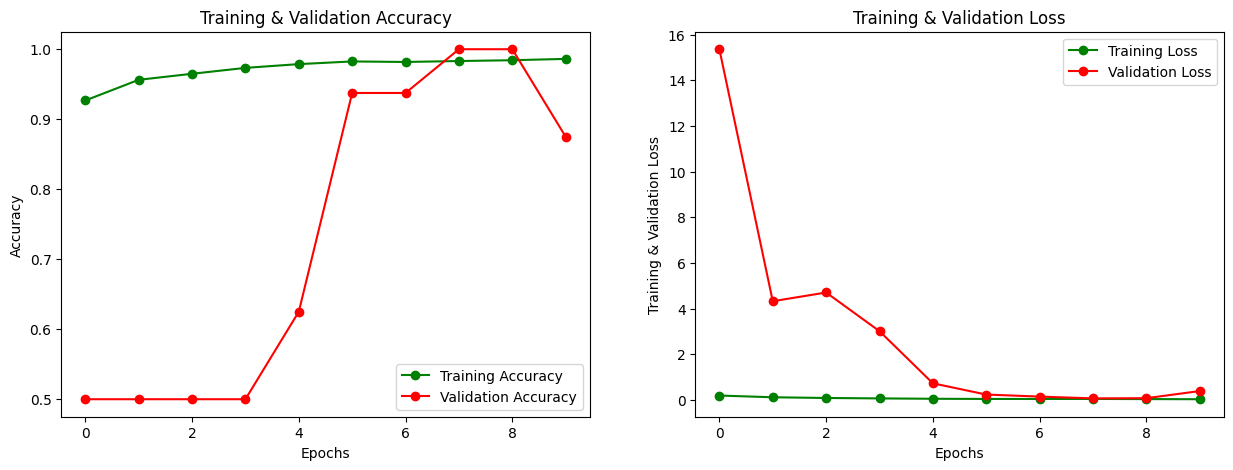

In [ ]:
# Plot Training and Validation accuracy and loss
epochs = [i for i in range(10)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(15, 5)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.88      0.99      0.93       390
   Normal (Class 1)       0.98      0.78      0.87       234

           accuracy                           0.91       624
          macro avg       0.93      0.88      0.90       624
       weighted avg       0.92      0.91      0.91       624



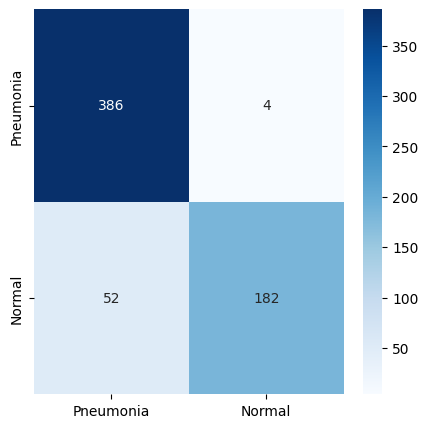

In [ ]:
# Predictions and evaluation
predictions = model.predict(x_test_rgb)
predictions = np.where(predictions > 0.5, 1, 0)

# Print classification report
print(classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

# Confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=['Pneumonia', 'Normal'], columns=['Pneumonia', 'Normal'])

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm_df, annot=True, fmt='', cmap="Blues")
plt.show()


In [ ]:
# Save the model
model.save('CNN_model.h5')
print("Model saved successfully!")


Model saved successfully!


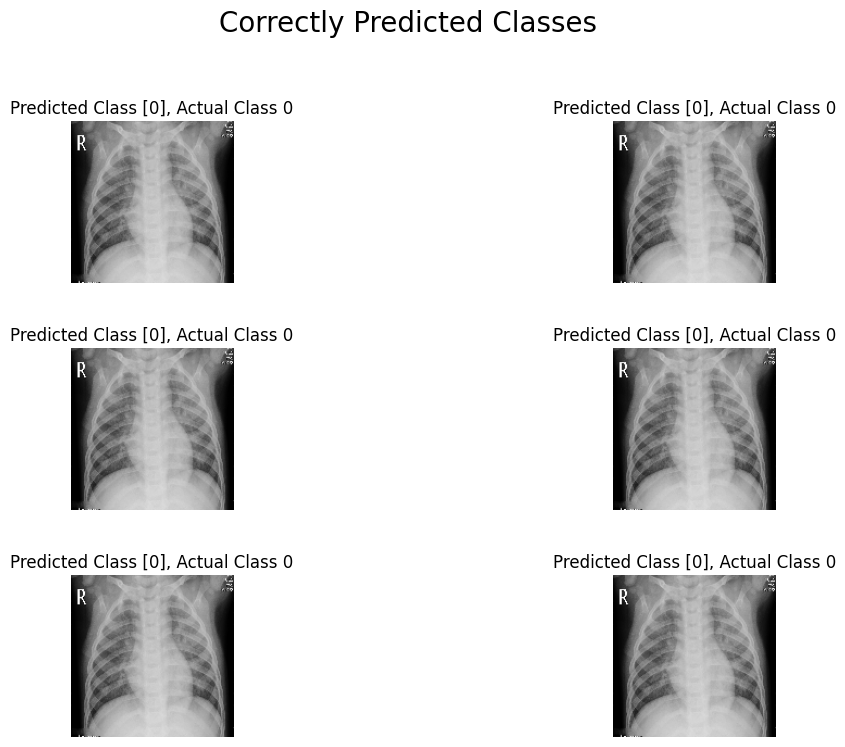

In [ ]:
# Get indices of correctly and incorrectly predicted classes
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

# Some of the Correctly Predicted Classes
plt.figure(figsize=(12, 8))
i = 0
for c in correct[:6]:s
    plt.subplot(3, 2, i + 1)
    plt.imshow(x_test_rgb[c].reshape(150, 150, 3))
    plt.title(f"Predicted Class {predictions[c]}, Actual Class {y_test[c]}")
    plt.axis('off')
    i += 1

plt.suptitle("Correctly Predicted Classes", fontsize=20, y=1.02)
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust space between subplots
plt.show()


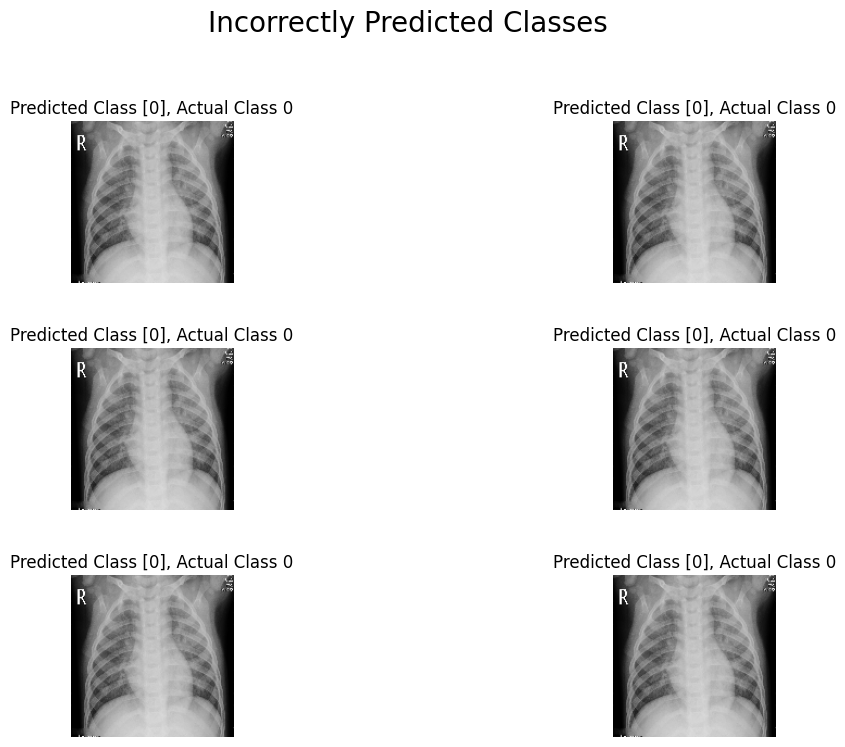

In [ ]:
# Some of the Incorrectly Predicted Classes
plt.figure(figsize=(12, 8))
i = 0
for c in incorrect[:6]:
    plt.subplot(3, 2, i + 1)
    plt.imshow(x_test_rgb[c].reshape(150, 150, 3))
    plt.title(f"Predicted Class {predictions[c]}, Actual Class {y_test[c]}")
    plt.axis('off')
    i += 1

plt.suptitle("Incorrectly Predicted Classes", fontsize=20, y=1.02)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()
`